In [1]:
import numpy as np
import nengo
from nengo.utils.ensemble import tuning_curves
import matplotlib
import matplotlib.pyplot as plt

In [168]:
def simulate_two_neuron_populations(
        stim_A, stim_B=None, n_A=21, n_B=22, T=1.0, dt=1e-4):
    with nengo.Network(seed=581) as model:
        nd_stim_A = nengo.Node(stim_A)
        if not stim_B is None:
            nd_stim_B = nengo.Node(stim_B)
        else:
            nd_stim_B = nd_stim_A

        ens_A = nengo.Ensemble(
            n_neurons=n_A, dimensions=1,
            max_rates=nengo.dists.Uniform(50, 100))
        ens_B = nengo.Ensemble(
            n_neurons=n_B, dimensions=1,
            max_rates=nengo.dists.Uniform(50, 100))

        nengo.Connection(nd_stim_A, ens_A, synapse=None)
        nengo.Connection(nd_stim_B, ens_B, synapse=None)

        p_stim_A = nengo.Probe(nd_stim_A, synapse=None)
        p_stim_B = nengo.Probe(nd_stim_B, synapse=None)

        p_ens_A = nengo.Probe(ens_A, synapse=10e-3)
        p_ens_B = nengo.Probe(ens_B, synapse=10e-3)

    with nengo.Simulator(model, dt=dt, progress_bar=None) as sim:
        sim.run(T)
        xs_A, A_A = tuning_curves(ens_A, sim)
        xs_B, A_B = tuning_curves(ens_B, sim)

    return \
        xs_A, A_A, \
        xs_B, A_B, \
        sim.trange(), \
        sim.data[p_stim_A], \
        sim.data[p_stim_B], \
        sim.data[p_ens_A], \
        sim.data[p_ens_B]

In [169]:
def plot_data(xs_A, A_A, xs_B, A_B, ts, stim_A, stim_B, ens_A, ens_B):
    fig = plt.figure(figsize=(6.5, 3.75))

    ax = plt.subplot2grid((5, 2), (0, 0), rowspan=3, colspan=1)
    ax.plot(xs_A, A_A)
    ax.set_xlabel('Represented value $x$')
    ax.set_ylabel('Firing rates $a_i(x)$ ($\\mathrm{s}^{-1}$)')
    ax.set_title('Population $A$ Tuning Curves ($n={}$)'.format(A_A.shape[1]))

    ax = plt.subplot2grid((5, 2), (0, 1), rowspan=3, colspan=1)
    ax.plot(xs_B, A_B)
    ax.set_xlabel('Represented value $x$')
    ax.set_ylabel('Firing rates $a_i(x)$ ($\\mathrm{s}^{-1}$)')
    ax.set_title('Population $B$ Tuning Curves ($m={}$)'.format(A_B.shape[1]))

    ax = plt.subplot2grid((5, 2), (3, 0), rowspan=2, colspan=2)
    ax.plot(ts, ens_A, label="Population $A$")
    ax.plot(ts, ens_B, label="Population $B$")
    ax.plot(ts, stim_A, 'k--')
    ax.set_ylim(-1.5, 1.5)
    ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(0, 1.1))
    ax.set_xlabel('Time $t$ (s)')
    ax.set_ylabel('Decoded value $\hat x(t)$')
    ax.set_title('Decoded values')

    fig.tight_layout(h_pad=-0.25);
    return fig

In [170]:
T, dt = 1.0, 1e-4
xs_A, A_A, xs_B, A_B, ts,\
stim_A, stim_B, ens_A, ens_B = \
    simulate_two_neuron_populations(
        nengo.processes.WhiteSignal(period=T, high=5.0, rms=0.5),
        T=T, dt=dt
    )

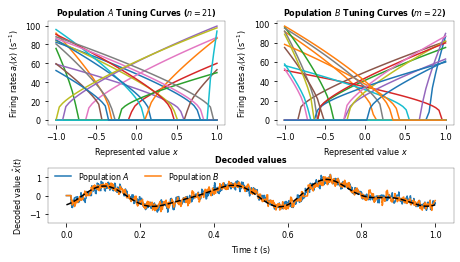

In [171]:
fig = plot_data(xs_A, A_A, xs_B, A_B, ts, stim_A, stim_B, ens_A, ens_B)
fig.savefig("../two_populations_decoding.pdf", transparent=True, bbox_inches='tight')

In [172]:
_, _, _, _, _,\
_, _, _, ens_B2 = \
    simulate_two_neuron_populations(
        nengo.processes.WhiteSignal(period=T, high=5.0, rms=0.5),
        lambda t: ens_A[int(t / dt) % ens_A.size],
        T=T, dt=dt
    )

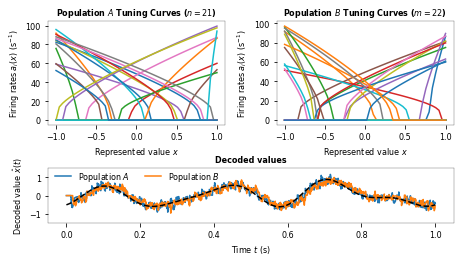

In [173]:
fig = plot_data(xs_A, A_A, xs_B, A_B, ts, stim_A, stim_B, ens_A, ens_B2)
fig.savefig("../two_populations_decoding_series.pdf", transparent=True, bbox_inches='tight')